In [15]:
import re
import json
from itertools import combinations
from datasketch import MinHash, MinHashLSH

In [16]:
# Load data
with open("TVs-all-merged.json", "r") as f:
    raw_data = json.load(f)
    
products = []
for modelID, shop_entries in raw_data.items():
    for entry in shop_entries:
        product = {
            "modelID": modelID,
            "shop": entry.get("shop"),
            "title": entry.get("title", ""),
            "attributes": entry.get("featuresMap", {})
        }
        products.append(product)

print(f"Total product instances: {len(products)}")
print(products[0])

Total product instances: 1624
{'modelID': '29PFL4508/F7', 'shop': 'bestbuy.com', 'title': 'Philips 4000 Series 29" Class 2812" Diag. LED 720p 60Hz HDTV 29PFL4508F7 - Best Buy', 'attributes': {'Screen Size Class': '29"', 'DVI Inputs': '0', 'ENERGY STAR Certified': 'Yes', 'Ethernet Port': 'No', 'Sleep Timer': 'Yes', 'Width': '27 inches', 'USB Port': 'Yes', 'TV Type': 'LED Flat-Panel', 'V-Chip': 'Yes', 'Component Video Inputs': '1', 'UPC': '609585230651', 'Screen Size (Measured Diagonally)': '28-1/2"', 'Mount Bracket/VESA Pattern': '100mm x 100mm', 'PC Inputs': '1', 'Aspect Ratio': '4:3 and 16:9', 'Audio Outputs': '1', 'Sound Leveler': 'Yes', 'Media Card Slot': 'No', 'Weight': '12.1 lbs. with stand (10.6 lbs. without)', 'Vertical Resolution': '720p', 'Composite Inputs': '1', 'Brightness': '270 cd/mÂ²', 'Watts/Channel': '8', 'HDMI Inputs': '3', 'Maximum Resolution': '1366 x 768', 'Screen Refresh Rate': '60Hz', 'Product Height (with stand)': '18-3/8"', 'Product Depth (without stand)': '2-5/

In [17]:
TV_BRANDS = {
    "acer","admiral","aiwa","akai","alba","amstrad","andrea smith electronics",
    "apex digital","apple","arcam","arise india","aga","audiovox","awa","baird",
    "bang & olufsen","beko","benq","binatone","blaupunkt","bpl","brionvega","bush",
    "canadian general electric","changhong","chimei","compal","conar","continental edison",
    "cossor","craig","crosley","curtis-mathes","daewoo","dell","delmonico","dumont",
    "durabrand","dynatron","english electric","ekco","electrohome","element electronics",
    "emerson","emi","farnsworth","ferguson","ferranti","finlux","fisher","fujitsu","funai",
    "geloso","general electric","goodmans","google","gradiente","graetz","grundig","haier",
    "hallicrafters","hannspree","heathkit","hinari","hisense","hitachi","hoffman","itel",
    "itt","jensen","jvc","kenmore","kent","kloss","kogan","kolster-brandes","konka","lanix",
    "le.com","lg","loewe","luxor","magnavox","marantz","marconiphone","matsui","memorex",
    "micromax","metz","mitsubishi","mivar","motorola","muntz","murphy","nec","nokia",
    "nordmende","onida","orion","packard bell","panasonic","pensonic","philco","philips",
    "pioneer","planar","polaroid","proline","proscan","pye","pyle","quasar","radioshack",
    "rauland-borg","rca","realistic","rediffusion","saba","salora","samsung","sansui",
    "sanyo","schneider","seiki","seleco","setchell carlson","sharp","siemens","skyworth",
    "sony","soyo","stromberg-carlson","supersonic","sylvania","symphonic","tandy","tatung",
    "tcl","technics","teco","teleavia","telefunken","teletronics","thomson","thorn","toshiba",
    "tpv","tp vision","ultra","united states television","vestel","videocon","videoton",
    "vizio","vu","walton","westinghouse","white-westinghouse","xiaomi","zanussi","zenith",
    "zonda"
}
TV_BRANDS = {b.lower() for b in TV_BRANDS}

def detect_brand_from_title(title: str):
    t = title.lower()
    for b in TV_BRANDS:
        if re.search(r"\b" + re.escape(b) + r"\b", t):
            return b
    return None

# Add brand field to products
for p in products:
    p["brand"] = detect_brand_from_title(p["title"])

In [18]:
print("\n=== Brand detection test (first 20 products) ===")
for i, p in enumerate(products[:20]):
    print(f"{i:02d}:  TITLE: {p['title']}")
    print(f"     DETECTED BRAND: {detect_brand_from_title(p['title'])}")


=== Brand detection test (first 20 products) ===
00:  TITLE: Philips 4000 Series 29" Class 2812" Diag. LED 720p 60Hz HDTV 29PFL4508F7 - Best Buy
     DETECTED BRAND: philips
01:  TITLE: Newegg.com - SuperSonic 32" 720p LED HDTV SC-3211
     DETECTED BRAND: supersonic
02:  TITLE: Sharp AQUOS 90" Class 90" Diag. LED 1080p 120Hz Smart 3D HDTV LC-90LE657U - Best Buy
     DETECTED BRAND: sharp
03:  TITLE: Philips 2000 Series 39" Class 3858" Diag. LED 1080p 60Hz Smart HDTV 39PFL2908F7 - Best Buy
     DETECTED BRAND: philips
04:  TITLE: Newegg.com - Sharp Aquos 70" Class (69.5" Diagonal) 1080p 120Hz LED-LCD HDTV - LC70LE550U
     DETECTED BRAND: sharp
05:  TITLE: Newegg.com - Refurbished: Samsung 40" 1080p 120Hz Smart LED HDTV - UN40F6350A
     DETECTED BRAND: samsung
06:  TITLE: Samsung 40" Class 40" Diag. LEDLCD TV 1080p HDTV 1080p HG40NA577LF - Best Buy
     DETECTED BRAND: samsung
07:  TITLE: Samsung 46" Class 46" Diag. LEDLCD TV 1080p HDTV 1080p Rose Black UN46F5000AF - Best Buy
     DE

In [19]:
import re

# Regex from the paper
model_word_regex = re.compile(
    r"[a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*"
)

def extract_model_words_full(product):
    title = product.get("title", "")
    words = set()

    for m in model_word_regex.finditer(title):
        full_word = m.group(0)

        if not full_word or len(full_word) <= 1:
            continue

        clean_word = full_word.strip("()[]{}<>")
        if not clean_word:
            continue

        if any(c.isdigit() for c in clean_word) and any(not c.isalnum() for c in clean_word):
            words.add(clean_word)
            continue

        if clean_word.isdigit():
            continue

        words.add(clean_word)

    return words

# Apply to all products
for p in products:
    p["model_words"] = extract_model_words_full(p)

In [20]:
# Inspect first 10 product titles and the model words extracted from their titles
print("=== Inspecting first 10 products ===\n")

for i, product in enumerate(products[:10]):
    title = product.get("title", "")
    model_id = product.get("modelID", "")
    shop = product.get("shop", "")
    
    words = extract_model_words_full(product)

    print(f"Product {i}")
    print(f"  modelID: {model_id}")
    print(f"  shop:    {shop}")
    print(f"  TITLE:   {title}")
    print(f"  MODEL WORDS extracted from title/attributes:")
    print(f"    {words}")
    print("-" * 60)
    print("-" * 50)

=== Inspecting first 10 products ===

Product 0
  modelID: 29PFL4508/F7
  shop:    bestbuy.com
  TITLE:   Philips 4000 Series 29" Class 2812" Diag. LED 720p 60Hz HDTV 29PFL4508F7 - Best Buy
  MODEL WORDS extracted from title/attributes:
    {'720p', '29"', '29PFL4508F7', '60Hz', '2812"'}
------------------------------------------------------------
--------------------------------------------------
Product 1
  modelID: SC-3211
  shop:    newegg.com
  TITLE:   Newegg.com - SuperSonic 32" 720p LED HDTV SC-3211
  MODEL WORDS extracted from title/attributes:
    {'SC-3211', '720p', '32"'}
------------------------------------------------------------
--------------------------------------------------
Product 2
  modelID: LC-90LE657U
  shop:    bestbuy.com
  TITLE:   Sharp AQUOS 90" Class 90" Diag. LED 1080p 120Hz Smart 3D HDTV LC-90LE657U - Best Buy
  MODEL WORDS extracted from title/attributes:
    {'LC-90LE657U', '90"', '3D', '1080p', '120Hz'}
-----------------------------------------------

In [21]:
import numpy as np
import re

# ------------------------------------------------------------
# 1) Build MW vocabulary correctly from title model words + brand
# ------------------------------------------------------------
MW = set()
for i, p in enumerate(products):
    words = p.get("model_words", set()).copy()  # model words from title

    # --- Data cleaning: unify -/_ before inch and hz, make lowercase ---
    cleaned_words = set()
    for w in words:
        w_clean = w.lower()
        w_clean = re.sub(r"[-_]+inch\b", "inch", w_clean)
        w_clean = re.sub(r"[-_]+hz\b", "hz", w_clean)
        cleaned_words.add(w_clean)

    brand = p.get("brand")
    if brand:
        # augment each model word with the brand, e.g., "samsung_720p"
        words_aug = {f"{brand}_{w}" for w in cleaned_words}
        p["model_words_aug"] = words_aug  # store augmented words
    else:
        p["model_words_aug"] = cleaned_words

    MW_before = len(MW)
    MW |= p["model_words_aug"]  # union
    MW_after = len(MW)

    # Print progress for first 10 products
    if i < 10:
        print(f"Product {i} ({p.get('modelID', 'N/A')}): added {MW_after - MW_before} new model words, total MW now {MW_after}")
        print(f"  Model words from title + brand: {p['model_words_aug']}")

# sort for consistent ordering
MW = sorted(MW)
mw_index = {mw: idx for idx, mw in enumerate(MW)}
MW_size = len(MW)

print(f"\nBuilt MW vocabulary size: {MW_size}")
print(f"First 100 model words: {MW[:100]}")

# ------------------------------------------------------------
# 2) Build binary vectors for all products (based on augmented model words)
# ------------------------------------------------------------
for p in products:
    vec = np.zeros(MW_size, dtype=np.uint8)
    for mw in p.get("model_words_aug", set()):
        idx = mw_index.get(mw)
        if idx is not None:
            vec[idx] = 1
    p["binary_vector"] = vec

# 3) Title-only vector
for p in products:
    tvec = np.zeros(MW_size, dtype=np.uint8)
    for mw in p.get("model_words_aug", set()):
        idx = mw_index.get(mw)
        if idx is not None:
            tvec[idx] = 1
    p["title_binary_vector"] = tvec

print("Binary vectors attached to products as 'binary_vector' and 'title_binary_vector'.")

Product 0 (29PFL4508/F7): added 5 new model words, total MW now 5
  Model words from title + brand: {'philips_29"', 'philips_60hz', 'philips_2812"', 'philips_720p', 'philips_29pfl4508f7'}
Product 1 (SC-3211): added 3 new model words, total MW now 8
  Model words from title + brand: {'supersonic_720p', 'supersonic_sc-3211', 'supersonic_32"'}
Product 2 (LC-90LE657U): added 5 new model words, total MW now 13
  Model words from title + brand: {'sharp_90"', 'sharp_3d', 'sharp_lc-90le657u', 'sharp_1080p', 'sharp_120hz'}
Product 3 (39PFL2908/F7): added 4 new model words, total MW now 17
  Model words from title + brand: {'philips_60hz', 'philips_39"', 'philips_1080p', 'philips_3858"', 'philips_39pfl2908f7'}
Product 4 (LC70LE550U): added 3 new model words, total MW now 20
  Model words from title + brand: {'sharp_70"', 'sharp_lc70le550u', 'sharp_.5', 'sharp_1080p', 'sharp_120hz'}
Product 5 (UN40F6350A): added 4 new model words, total MW now 24
  Model words from title + brand: {'samsung_120hz'

In [22]:
# ---------------------------
# Determine b and r for each threshold t
# ---------------------------
n_perm_base = MW_size // 2  # number of permutations based on vocabulary size

# More granular thresholds: 0.10, 0.15, 0.20, ..., 0.95
thresholds = np.arange(0.051, 0.951, 0.05)

max_r = 60  # maximum rows per band

chosen_params = []

for t in thresholds:
    best_diff = float('inf')
    best_r, best_b, best_n_perm, best_t_approx = None, None, None, None

    for r in range(1, max_r + 1):
        b = max(1, round(n_perm_base / r))  # number of bands
        n_perm = b * r
        t_approx = (1 / b)**(1 / r)
        diff = abs(t_approx - t)

        # Keep the combination that minimizes |t_approx - t|
        if diff < best_diff:
            best_diff = diff
            best_r, best_b, best_n_perm, best_t_approx = r, b, n_perm, t_approx

    # store the best combination for this threshold
    chosen_params.append({
        "threshold": t,
        "r": best_r,
        "b": best_b,
        "t_approx": best_t_approx,
        "n_perm": best_n_perm
    })

# display selected parameters
import pandas as pd
df_params = pd.DataFrame(chosen_params)
print(df_params)

    threshold   r    b  t_approx  n_perm
0       0.051   2  434  0.048002     868
1       0.101   3  289  0.151252     867
2       0.151   3  289  0.151252     867
3       0.201   3  289  0.151252     867
4       0.251   4  217  0.260546     868
5       0.301   4  217  0.260546     868
6       0.351   5  173  0.356772     865
7       0.401   6  144  0.436790     864
8       0.451   6  144  0.436790     864
9       0.501   7  124  0.502273     868
10      0.551   8  108  0.556957     864
11      0.601   9   96  0.602210     864
12      0.651  10   87  0.639806     870
13      0.701  12   72  0.700200     864
14      0.751  14   62  0.744684     868
15      0.801  18   48  0.806488     864
16      0.851  23   38  0.853717     874
17      0.901  32   27  0.902132     864


In [23]:
# === LSH-only bootstrap pipeline with threshold evaluation ===
# Requirements: numpy, pandas, plotnine
import numpy as np
import random
import itertools
from collections import defaultdict, Counter
import math
import time
import pandas as pd

# ---------------------------
# Safety checks / assumptions
# ---------------------------
if 'products' not in globals():
    raise RuntimeError("`products` not found in environment.")
if 'MW' not in globals():
    MW = sorted({mw for p in products for mw in p.get("model_words", set())})
mw_index = {mw: idx for idx, mw in enumerate(MW)}
MW_size = len(MW)

# Ensure binary vectors exist
if "binary_vector" not in products[0]:
    for p in products:
        vec = np.zeros(MW_size, dtype=np.uint8)
        for mw in p.get("model_words", set()):
            idx = mw_index.get(mw)
            if idx is not None:
                vec[idx] = 1
        p["binary_vector"] = vec

# ---------------------------
# Helper functions (custom)
# ---------------------------
PRIME = 4294967311

def sample_hash_funcs(num_perm, seed=None, prime=PRIME):
    rng = random.Random(seed if seed is not None else 0)
    return [(rng.randint(1, prime-1), rng.randint(0, prime-1)) for _ in range(num_perm)]

def compute_minhash(binary_vector, hash_funcs, prime=PRIME):
    idxs = np.nonzero(binary_vector)[0]
    k = len(hash_funcs)
    if idxs.size == 0:
        return np.full(k, np.iinfo(np.int64).max, dtype=np.int64)
    sig = np.empty(k, dtype=np.int64)
    for i, (a, b) in enumerate(hash_funcs):
        vals = (a + (b * idxs.astype(np.int64))) % prime
        sig[i] = int(vals.min())
    return sig

def build_buckets_from_signatures(signatures, rows_per_band):
    buckets = defaultdict(list)
    if len(signatures) == 0:
        return buckets
    sig_len = signatures[0].size
    if sig_len % rows_per_band != 0:
        raise ValueError("rows_per_band must divide signature length")
    bands = sig_len // rows_per_band
    for i, sig in enumerate(signatures):
        for b in range(bands):
            start = b * rows_per_band
            end = start + rows_per_band
            key = (b, tuple(int(x) for x in sig[start:end]))
            buckets[key].append(i)
    return buckets

def candidate_pairs_from_buckets(buckets):
    pairs = set()
    for items in buckets.values():
        if len(items) > 1:
            for a, b in itertools.combinations(sorted(items), 2):
                pairs.add((a,b))
    return sorted(pairs)

def evaluate_candidate_set(candidate_pairs, product_list):
    Nc = len(candidate_pairs)
    Df = sum(1 for (i,j) in candidate_pairs if product_list[i]['modelID']==product_list[j]['modelID'])
    model_to_idxs = defaultdict(list)
    for idx, p in enumerate(product_list):
        model_to_idxs[p['modelID']].append(idx)
    Dn_pairs = set()
    for idxs in model_to_idxs.values():
        if len(idxs)>=2:
            for a,b in itertools.combinations(sorted(idxs),2):
                Dn_pairs.add((a,b))
    Dn = len(Dn_pairs)
    PQ = Df / Nc if Nc>0 else 0.0
    PC = Df / Dn if Dn>0 else 0.0
    F1 = 2*PQ*PC/(PQ+PC) if (PQ+PC)>0 else 0.0
    return PQ, PC, F1, Df, Nc, Dn

# ---------------------------
# Bootstrap setup
# ---------------------------
random.seed(12345)
np.random.seed(12345)

num_bootstraps = 5
bootstrap_fraction = 0.60
n_perm_base = MW_size // 2      # base number of permutations
max_r = 16                      # maximum rows per band

# ---------------------------
# Stratified bootstrap indices
# ---------------------------
model_map_global = defaultdict(list)
for idx, p in enumerate(products):
    model_map_global[p['modelID']].append(idx)
cluster_sizes = [len(v) for v in model_map_global.values()]
size_counts = Counter(cluster_sizes)
bootstrap_size = int(math.ceil(len(products) * bootstrap_fraction))

def stratified_bootstrap_indices():
    sampled = []
    for size, cnt in size_counts.items():
        clusters_of_size = [v for v in model_map_global.values() if len(v)==size]
        num_to_sample = max(1, int(round(cnt*bootstrap_fraction)))
        sampled_clusters = random.sample(clusters_of_size, min(num_to_sample, len(clusters_of_size)))
        for cl in sampled_clusters:
            sampled.extend(cl)
    if len(sampled) > bootstrap_size:
        sampled = random.sample(sampled, bootstrap_size)
    elif len(sampled) < bootstrap_size:
        remaining = list(set(range(len(products))) - set(sampled))
        deficit = bootstrap_size - len(sampled)
        if remaining:
            sampled.extend(random.sample(remaining, min(deficit,len(remaining))))
    return sampled[:bootstrap_size]

# ---------------------------
# Run LSH-only bootstrap
# ---------------------------
results_thresholds = []

for bidx in range(num_bootstraps):
    t_b0 = time.time()
    print(f"\n--- Bootstrap {bidx+1}/{num_bootstraps} ---")
    bs_idxs = stratified_bootstrap_indices()
    bootstrap_products = [products[i] for i in bs_idxs]
    local_vectors = [p['binary_vector'] for p in bootstrap_products]

    for param in chosen_params:
        t = param["threshold"]
        r = param["r"]
        b = param["b"]
        n_perm = param["n_perm"]

        hash_funcs = sample_hash_funcs(n_perm, seed=12345+bidx)
        try:
            signatures = [compute_minhash(v, hash_funcs) for v in local_vectors]
            buckets = build_buckets_from_signatures(signatures, rows_per_band=r)
            cand_pairs = candidate_pairs_from_buckets(buckets)
        except Exception as e:
            print(f"  Threshold {t:.2f}: error building buckets with r={r}: {e}")
            continue

        # Filter candidate pairs
        cand_pairs_filtered = []
        for (i,j) in cand_pairs:
            pi = bootstrap_products[i]; pj = bootstrap_products[j]
            if pi.get("shop") == pj.get("shop"):
                continue
            bi = pi.get("brand"); bj = pj.get("brand")
            if bi and bj and bi != bj:
                continue
            cand_pairs_filtered.append(tuple(sorted((i,j))))

        PQ, PC, F1, Df, Nc, Dn = evaluate_candidate_set(cand_pairs_filtered, bootstrap_products)
        print(f"  Threshold {t:.2f}: b={b}, r={r} -> PQ={PQ:.4f}, PC={PC:.4f}, F1={F1:.4f} (Nc={Nc}, Df={Df}, Dn={Dn})")

        results_thresholds.append({
            "bootstrap": bidx,
            "threshold": t,
            "b": b,
            "r": r,
            "PQ": PQ,
            "PC": PC,
            "F1": F1,
            "Nc": Nc,
            "Df": Df,
            "Dn": Dn
        })

    t_b1 = time.time()
    print(f"Bootstrap {bidx+1} done in {t_b1 - t_b0:.1f}s")

# ---------------------------
# Aggregate and plot results
# ---------------------------
try:
    import plotnine as p9
except:
    raise RuntimeError("Install plotnine for ggplot-style plotting: pip install plotnine")

df_lsh = pd.DataFrame(results_thresholds)
df_avg = df_lsh.groupby("threshold")[["PQ","PC","F1"]].mean().reset_index()

plot_PC = (p9.ggplot(df_avg, p9.aes(x="threshold", y="PC")) +
           p9.geom_line() + p9.labs(title="PC vs Threshold") + p9.theme_minimal())
plot_PQ = (p9.ggplot(df_avg, p9.aes(x="threshold", y="PQ")) +
           p9.geom_line() + p9.labs(title="PQ vs Threshold") + p9.theme_minimal())
plot_F1 = (p9.ggplot(df_avg, p9.aes(x="threshold", y="F1")) +
           p9.geom_line() + p9.labs(title="F1 vs Threshold") + p9.theme_minimal())

print(df_avg)
plot_PC, plot_PQ, plot_F1


--- Bootstrap 1/5 ---
  Threshold 0.05: b=434, r=2 -> PQ=0.0087, PC=0.9409, F1=0.0172 (Nc=25619, Df=223, Dn=237)
  Threshold 0.10: b=289, r=3 -> PQ=0.0136, PC=0.9409, F1=0.0268 (Nc=16379, Df=223, Dn=237)
  Threshold 0.15: b=289, r=3 -> PQ=0.0136, PC=0.9409, F1=0.0268 (Nc=16379, Df=223, Dn=237)
  Threshold 0.20: b=289, r=3 -> PQ=0.0136, PC=0.9409, F1=0.0268 (Nc=16379, Df=223, Dn=237)
  Threshold 0.25: b=217, r=4 -> PQ=0.0271, PC=0.8776, F1=0.0526 (Nc=7671, Df=208, Dn=237)
  Threshold 0.30: b=217, r=4 -> PQ=0.0271, PC=0.8776, F1=0.0526 (Nc=7671, Df=208, Dn=237)
  Threshold 0.35: b=173, r=5 -> PQ=0.0514, PC=0.8186, F1=0.0967 (Nc=3775, Df=194, Dn=237)
  Threshold 0.40: b=144, r=6 -> PQ=0.0884, PC=0.7426, F1=0.1581 (Nc=1990, Df=176, Dn=237)
  Threshold 0.45: b=144, r=6 -> PQ=0.0884, PC=0.7426, F1=0.1581 (Nc=1990, Df=176, Dn=237)
  Threshold 0.50: b=124, r=7 -> PQ=0.1376, PC=0.6624, F1=0.2279 (Nc=1141, Df=157, Dn=237)
  Threshold 0.55: b=108, r=8 -> PQ=0.2098, PC=0.6160, F1=0.3130 (Nc=696, 

(<plotnine.ggplot.ggplot object at 0x168e22ed0>,
 <plotnine.ggplot.ggplot object at 0x17b27c810>)

Averaged results:
    threshold        PQ        PC        F1
0       0.051  0.008785  0.943460  0.017408
1       0.101  0.013365  0.935021  0.026350
2       0.151  0.013365  0.935021  0.026350
3       0.201  0.013365  0.935021  0.026350
4       0.251  0.025367  0.875949  0.049303
5       0.301  0.025367  0.875949  0.049303
6       0.351  0.045279  0.811814  0.085752
7       0.401  0.083172  0.720675  0.149061
8       0.451  0.083172  0.720675  0.149061
9       0.501  0.139145  0.648101  0.228888
10      0.551  0.194470  0.578903  0.291020
11      0.601  0.260599  0.500422  0.342498
12      0.651  0.296086  0.439662  0.353259
13      0.701  0.359633  0.330802  0.343847
14      0.751  0.403285  0.247257  0.305739
15      0.801  0.453416  0.122363  0.192532
16      0.851  0.610533  0.072574  0.129620
17      0.901  0.764566  0.049789  0.093329


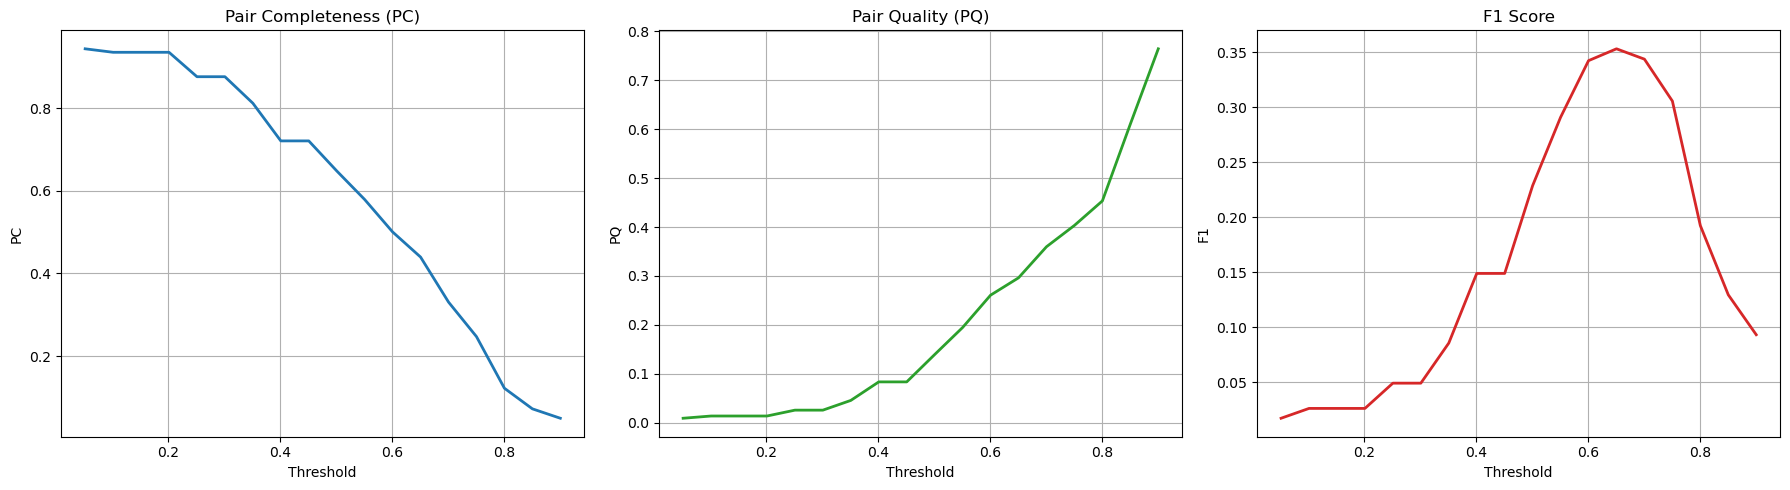

In [24]:
# ===========================
# Matplotlib Combined Plot (horizontal)
# ===========================

import pandas as pd
import matplotlib.pyplot as plt

# Ensure df_lsh exists
if "df_lsh" not in globals():
    raise RuntimeError("df_lsh not found – run the bootstrap loop first.")

# Aggregate results over bootstraps
df_avg = df_lsh.groupby("threshold")[["PQ", "PC", "F1"]].mean().reset_index()

print("Averaged results:")
print(df_avg)

# ------------------------
# Create combined horizontal figure
# ------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Pair Completeness
axs[0].plot(df_avg["threshold"], df_avg["PC"], linewidth=2, color='tab:blue')
axs[0].set_title("Pair Completeness (PC)")
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("PC")
axs[0].grid(True)

# Pair Quality
axs[1].plot(df_avg["threshold"], df_avg["PQ"], linewidth=2, color='tab:green')
axs[1].set_title("Pair Quality (PQ)")
axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("PQ")
axs[1].grid(True)

# F1 Score
axs[2].plot(df_avg["threshold"], df_avg["F1"], linewidth=2, color='tab:red')
axs[2].set_title("F1 Score")
axs[2].set_xlabel("Threshold")
axs[2].set_ylabel("F1")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [25]:
# ---------------------------
# Extract / populate KVPs for all products
# ---------------------------

for p in products:
    kvps = []

    # Example 1: structured attributes if present
    attributes = p.get("attributes", {})  # dict of key-value pairs
    for k, v in attributes.items():
        if k and v:
            kvps.append({"key": str(k), "value": str(v)})

    # Example 2: include model_words as a special key
    for mw in p.get("model_words", set()):
        kvps.append({"key": "model_word", "value": str(mw)})

    # Example 3: optionally parse title for key:value patterns
    title = p.get("title", "")
    if title:
        # very simple regex to extract key:value pairs from title
        import re
        matches = re.findall(r"(\w+):\s*([\w-]+)", title)
        for k, v in matches:
            kvps.append({"key": k, "value": v})

    p["kvp"] = kvps

In [26]:
# ===========================
# Extended LSH + XGBoost bootstrap pipeline
# ===========================

import numpy as np
import random
import itertools
from collections import defaultdict, Counter
import math
import time
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score

# ---------------------------
# Safety checks / assumptions
# ---------------------------
if 'products' not in globals():
    raise RuntimeError("`products` not found in environment.")
if 'MW' not in globals():
    MW = sorted({mw for p in products for mw in p.get("model_words", set())})
mw_index = {mw: idx for idx, mw in enumerate(MW)}
MW_size = len(MW)

# Ensure binary vectors exist
if "binary_vector" not in products[0]:
    for p in products:
        vec = np.zeros(MW_size, dtype=np.uint8)
        for mw in p.get("model_words", set()):
            idx = mw_index.get(mw)
            if idx is not None:
                vec[idx] = 1
        p["binary_vector"] = vec

# ---------------------------
# Bootstrap setup
# ---------------------------
random.seed(12345)
np.random.seed(12345)

num_bootstraps = 10
bootstrap_fraction = 0.60

# Stratified bootstrap
model_map_global = defaultdict(list)
for idx, p in enumerate(products):
    model_map_global[p['modelID']].append(idx)
cluster_sizes = [len(v) for v in model_map_global.values()]
size_counts = Counter(cluster_sizes)
bootstrap_size = int(math.ceil(len(products) * bootstrap_fraction))

def stratified_bootstrap_indices():
    sampled = []
    for size, cnt in size_counts.items():
        clusters_of_size = [v for v in model_map_global.values() if len(v)==size]
        num_to_sample = max(1, int(round(cnt*bootstrap_fraction)))
        sampled_clusters = random.sample(clusters_of_size, min(num_to_sample, len(clusters_of_size)))
        for cl in sampled_clusters:
            sampled.extend(cl)
    if len(sampled) > bootstrap_size:
        sampled = random.sample(sampled, bootstrap_size)
    elif len(sampled) < bootstrap_size:
        remaining = list(set(range(len(products))) - set(sampled))
        deficit = bootstrap_size - len(sampled)
        if remaining:
            sampled.extend(random.sample(remaining, min(deficit,len(remaining))))
    return sampled[:bootstrap_size]

# ---------------------------
# Storage for evaluation results
# ---------------------------
eval_results = []

# ---------------------------
# Run bootstraps
# ---------------------------
for bidx in range(num_bootstraps):
    t0 = time.time()
    print(f"\n--- Bootstrap {bidx+1}/{num_bootstraps} ---")

    # Sample bootstrap and evaluation sets
    bs_idxs = stratified_bootstrap_indices()
    bootstrap_products = [products[i] for i in bs_idxs]
    eval_idxs = list(set(range(len(products))) - set(bs_idxs))
    eval_products = [products[i] for i in eval_idxs]
    local_vectors_bs = [p['binary_vector'] for p in bootstrap_products]
    local_vectors_eval = [p['binary_vector'] for p in eval_products]

    # ---------------------------
    # Evaluate all LSH parameters on bootstrap
    # ---------------------------
    lsh_metrics_bs = []
    for param in chosen_params:
        t = param["threshold"]
        r = param["r"]
        b = param["b"]
        n_perm = param["n_perm"]

        hash_funcs = sample_hash_funcs(n_perm, seed=12345+bidx)
        try:
            signatures = [compute_minhash(v, hash_funcs) for v in local_vectors_bs]
            buckets = build_buckets_from_signatures(signatures, rows_per_band=r)
            cand_pairs = candidate_pairs_from_buckets(buckets)
        except Exception as e:
            continue

        # Filter candidate pairs
        cand_pairs_filtered = []
        for (i,j) in cand_pairs:
            pi, pj = bootstrap_products[i], bootstrap_products[j]
            if pi.get("shop") == pj.get("shop"):
                continue
            bi, bj = pi.get("brand"), pj.get("brand")
            if bi and bj and bi != bj:
                continue
            cand_pairs_filtered.append(tuple(sorted((i,j))))

        PQ, PC, F1, Df, Nc, Dn = evaluate_candidate_set(cand_pairs_filtered, bootstrap_products)
        lsh_metrics_bs.append((param, F1, cand_pairs_filtered, PQ, PC))

    # Choose best LSH param (highest F1)
    best_param, best_F1, best_cand_pairs_bs, PQ_bs, PC_bs = max(lsh_metrics_bs, key=lambda x: x[1])
    r_best, b_best, n_perm_best = best_param['r'], best_param['b'], best_param['n_perm']
    print(f"Selected best LSH param for bootstrap {bidx+1}: threshold={best_param['threshold']:.3f}, r={r_best}, b={b_best}, F1={best_F1:.4f}")

    # ---------------------------
    # Apply best LSH to evaluation set
    # ---------------------------
    hash_funcs_eval = sample_hash_funcs(n_perm_best, seed=54321+bidx)
    signatures_eval = [compute_minhash(v, hash_funcs_eval) for v in local_vectors_eval]
    buckets_eval = build_buckets_from_signatures(signatures_eval, rows_per_band=r_best)
    cand_pairs_eval = candidate_pairs_from_buckets(buckets_eval)

    # Filter candidate pairs for eval
    eval_pairs_filtered = []
    for (i,j) in cand_pairs_eval:
        pi, pj = eval_products[i], eval_products[j]
        if pi.get("shop") == pj.get("shop"):
            continue
        bi, bj = pi.get("brand"), pj.get("brand")
        if bi and bj and bi != bj:
            continue
        eval_pairs_filtered.append((i,j))

    PQ_eval_lsh, PC_eval_lsh, F1_eval_lsh, _, Nc_eval, Dn_eval = evaluate_candidate_set(eval_pairs_filtered, eval_products)
    print(f"LSH performance on eval set: PQ={PQ_eval_lsh:.4f}, PC={PC_eval_lsh:.4f}, F1={F1_eval_lsh:.4f}")

    # ---------------------------
    # Prepare XGBoost features (model_words, title_words, brand, kvps)
    # ---------------------------
    def jaccard_similarity(set1, set2):
        if not set1 or not set2:
            return 0.0
        return len(set1 & set2) / len(set1 | set2)

    def extract_kvp_features(pi, pj):
        kvp_i = pi.get("kvp", [])
        kvp_j = pj.get("kvp", [])
        keys_i = set((q["key"], q["value"]) for q in kvp_i)
        keys_j = set((q["key"], q["value"]) for q in kvp_j)
        return jaccard_similarity(keys_i, keys_j)

    X_train, y_train = [], []
    for i,j in best_cand_pairs_bs:
        pi, pj = bootstrap_products[i], bootstrap_products[j]
        features = [
            jaccard_similarity(set(pi.get("model_words", set())), set(pj.get("model_words", set()))),
            jaccard_similarity(set(pi.get("title_words", set())), set(pj.get("title_words", set()))),
            int(pi.get("brand") == pj.get("brand")),
            extract_kvp_features(pi, pj)
        ]
        X_train.append(features)
        y_train.append(int(pi['modelID'] == pj['modelID']))
    X_train = np.array(X_train); y_train = np.array(y_train)

    # ---------------------------
    # Prepare eval XGBoost features
    # ---------------------------
    X_eval, y_eval = [], []
    for i,j in eval_pairs_filtered:
        pi, pj = eval_products[i], eval_products[j]
        features = [
            jaccard_similarity(set(pi.get("model_words", set())), set(pj.get("model_words", set()))),
            jaccard_similarity(set(pi.get("title_words", set())), set(pj.get("title_words", set()))),
            int(pi.get("brand") == pj.get("brand")),
            extract_kvp_features(pi, pj)
        ]
        X_eval.append(features)
        y_eval.append(int(pi['modelID'] == pj['modelID']))
    X_eval = np.array(X_eval); y_eval = np.array(y_eval)

    # ---------------------------
    # Train XGBoost
    # ---------------------------
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_eval, label=y_eval)
    params_xgb = {"objective":"binary:logistic","eval_metric":"logloss","use_label_encoder":False,"seed":12345}
    bst = xgb.train(params_xgb, dtrain, num_boost_round=100)

    y_pred_prob = bst.predict(dtest)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred)
    print(f"XGBoost performance on eval set: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    eval_results.append({
        "bootstrap": bidx,
        "PQ_lsh": PQ_eval_lsh, "PC_lsh": PC_eval_lsh, "F1_lsh": F1_eval_lsh,
        "Precision_xgb": precision, "Recall_xgb": recall, "F1_xgb": f1,
        "Nc_lsh": Nc_eval, "Dn_lsh": Dn_eval
    })

    t1 = time.time()
    print(f"Bootstrap {bidx+1} done in {t1-t0:.1f}s")

# ---------------------------
# Report averages
# ---------------------------
df_eval = pd.DataFrame(eval_results)
avg_metrics = df_eval.mean(numeric_only=True)
print("\nAverage evaluation metrics across bootstraps:")
print(avg_metrics)


--- Bootstrap 1/10 ---
Selected best LSH param for bootstrap 1: threshold=0.651, r=10, b=87, F1=0.3576
LSH performance on eval set: PQ=0.3787, PC=0.3951, F1=0.3867
XGBoost performance on eval set: Precision=0.6909, Recall=0.5938, F1=0.6387
Bootstrap 1 done in 43.9s

--- Bootstrap 2/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 2: threshold=0.651, r=10, b=87, F1=0.3879
LSH performance on eval set: PQ=0.4114, PC=0.4472, F1=0.4286
XGBoost performance on eval set: Precision=0.6724, Recall=0.5417, F1=0.6000
Bootstrap 2 done in 43.2s

--- Bootstrap 3/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:24:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 3: threshold=0.651, r=10, b=87, F1=0.3734
LSH performance on eval set: PQ=0.3450, PC=0.4313, F1=0.3833
XGBoost performance on eval set: Precision=0.6774, Recall=0.6087, F1=0.6412
Bootstrap 3 done in 43.0s

--- Bootstrap 4/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:25:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 4: threshold=0.701, r=12, b=72, F1=0.3293
LSH performance on eval set: PQ=0.4747, PC=0.2919, F1=0.3615
XGBoost performance on eval set: Precision=0.7778, Recall=0.5957, F1=0.6747
Bootstrap 4 done in 42.5s

--- Bootstrap 5/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 5: threshold=0.601, r=9, b=96, F1=0.3545
LSH performance on eval set: PQ=0.3779, PC=0.5093, F1=0.4339
XGBoost performance on eval set: Precision=0.7931, Recall=0.5610, F1=0.6571
Bootstrap 5 done in 43.2s

--- Bootstrap 6/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:26:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 6: threshold=0.651, r=10, b=87, F1=0.3681
LSH performance on eval set: PQ=0.3770, PC=0.4472, F1=0.4091
XGBoost performance on eval set: Precision=0.6341, Recall=0.3611, F1=0.4602
Bootstrap 6 done in 42.5s

--- Bootstrap 7/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 7: threshold=0.651, r=10, b=87, F1=0.3902
LSH performance on eval set: PQ=0.3371, PC=0.3665, F1=0.3512
XGBoost performance on eval set: Precision=0.6275, Recall=0.5424, F1=0.5818
Bootstrap 7 done in 43.5s

--- Bootstrap 8/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:28:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 8: threshold=0.651, r=10, b=87, F1=0.3328
LSH performance on eval set: PQ=0.4512, PC=0.4568, F1=0.4540
XGBoost performance on eval set: Precision=0.6875, Recall=0.4459, F1=0.5410
Bootstrap 8 done in 43.7s

--- Bootstrap 9/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:28:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 9: threshold=0.651, r=10, b=87, F1=0.3295
LSH performance on eval set: PQ=0.4780, PC=0.4720, F1=0.4750
XGBoost performance on eval set: Precision=0.8718, Recall=0.4474, F1=0.5913
Bootstrap 9 done in 43.7s

--- Bootstrap 10/10 ---


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Selected best LSH param for bootstrap 10: threshold=0.651, r=10, b=87, F1=0.3930
LSH performance on eval set: PQ=0.3553, PC=0.4403, F1=0.3933
XGBoost performance on eval set: Precision=0.5882, Recall=0.5714, F1=0.5797
Bootstrap 10 done in 43.5s

Average evaluation metrics across bootstraps:
bootstrap          4.500000
PQ_lsh             0.398640
PC_lsh             0.425751
F1_lsh             0.407654
Precision_xgb      0.702075
Recall_xgb         0.526906
F1_xgb             0.596571
Nc_lsh           174.600000
Dn_lsh           160.900000
dtype: float64


/opt/anaconda3/envs/cs_env/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:30:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

